Workflow:


1.   Read in the data from the mdf file, take a look at channel names/some channels for sanity checking
2.   Convert the data to an evenly-spaced (by time) data frame using interpolation
3. Transform the data into the form we need to test the model (e.g. from lat/long to an inertial frame). This transformed data will be the base for model tuning/validation, so save it to a csv.
4. Choose one of the following ways:

*   Given some initial state and control action sequence, use the ModelExplorer to compare simulated vs real data interactively
*   Choose a stride (either 1 or 16 recommended). Then create the L2 loss report or run the optimizer.





Current optimization plan:
1. We are first going to optimize using both parameter files for the tires
2. Optimize for every parameter (except car/wheel rotational inertia) first by focusing on the x,y time derivatives

Problem: While both training and validation error is good, the numbers are quite nonsensical (aero coefficient of 10) 

Seems like Acc_Z and v^2 have no discernible pattern

Check that acc_x and acc_y accurately predict next vlong and vlat
IT DOES: Error is between 0.01 and 0.02

Okay, after removing the bound on aero downforce coefficient, it has been optimized to 85, with a validation loss of [0.043, 0.032]. What to do now?

- Test out optimizing against acc_x and acc_y preliminarily - write it gradient based
- Do I need to improve the model?

3. Using those optimum parameters, optimize wheel rotational intertia and decide on whether to include rolling drag + air resistance
4. Repeat steps 1 to 3 if results are unsatisfactory
5. If neither result is satisfactory, schedule a code-checkin with Manan, and check out autograd, and get Mahika to train a neural net

In [1]:
%%capture
%pip install matplotlib
%pip install scipy
%pip install scikit-learn

%pip install asammdf
%pip install ipympl
%pip install mpl_interactions
%pip install mpl_interactions[jupyter]
%pip install autograd

Completed
- Make the plotting able to take in the data frame
- Split into training and validation sets
- Verify the report generation works
- Implement strided passes in the report (since the model has to be accurate only for 16 timesteps)
- Provide a way to interactively tune parameters to see if
- Try running mpl_interactions locally (not on jupyter) to see if it will be less laggy
- Create transform functions to get signal data to be model-ready (e.g. transform lat/long to x and y, swap axes)



In [2]:
%matplotlib ipympl

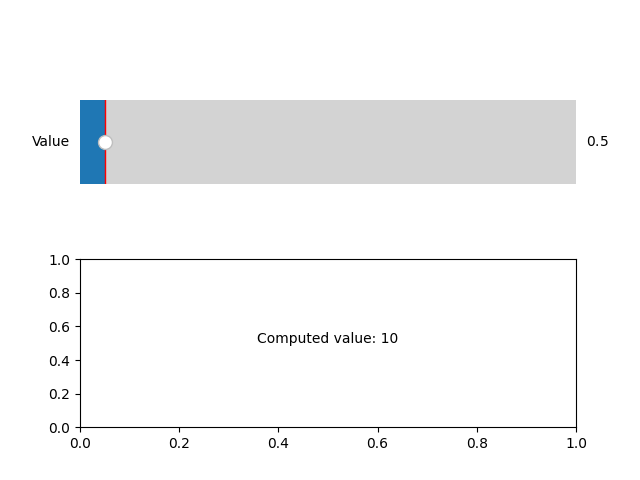

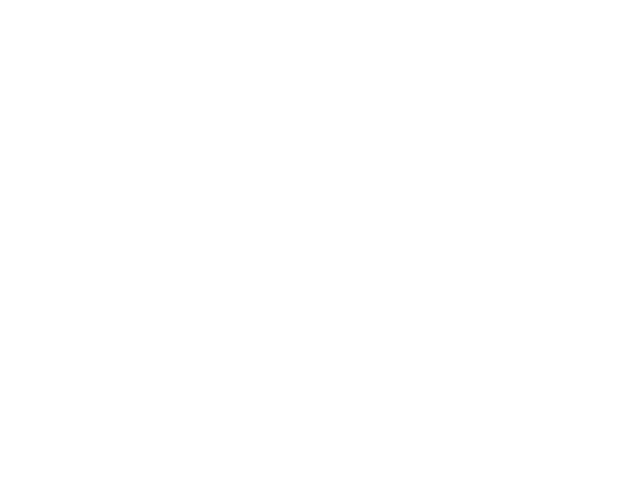

In [3]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Initial value
init_val = 5

plt.clf()
# Create the figure and axis
fig, (ax1, ax2) = plt.subplots(nrows=2)
# plt.subplots_adjust(bottom=0.2)  # make space for the slider

# Create the slider
# ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
slider = Slider(ax1, 'Value', 0, 10)

# Create the text box
# ax_text = plt.axes([0.25, 0.05, 0.65, 0.03])
text_box = ax2.text(0.5, 0.5, f'Computed value: {init_val*2}', ha='center')

# Update function
def update(val):
    text_box.set_text(f'Computed value: {val*2}')
    fig.canvas.draw_idle()

# Register the update function with the slider
slider.on_changed(update)

plt.show()

In [4]:
from asammdf import MDF, Signal
import pickle
import pandas as pd
import autograd.numpy as np
# import autograd.numpy as np
import math
from scipy.interpolate import interp1d
from scipy.optimize import minimize, approx_fprime, basinhopping
from scipy.spatial.transform import Rotation
from scipy.spatial.transform import Slerp
import matplotlib.pyplot as plt
import mpl_interactions.ipyplot as iplt
import random
from tire_model import get_forces
import sys
from autograd import grad

ldf is not supported
xls is not supported
xlsx is not supported
yaml is not supported


In [5]:
# Parameters
timestep = 0.02 # seconds
data_filename = "CAN_RUN1.mdf"
gps_filename = "MT_RUN1-MASTER-NOGNSS.txt"

torque_directions = ['FR', 'FL', 'RR', 'BL']

# Columns for GPS data

gps_latitude_channel = "Latitude"
gps_longitude_channel = "Longitude"
gps_velocity_x_channel = "Vel_E"
gps_velocity_y_channel = "Vel_N"
gps_rate_of_turn_channel = "Gyr_Z"
gps_acceleration_x_channel = "Acc_X"
gps_acceleration_y_channel = "Acc_Y"
gps_acceleration_z_channel = "Acc_Z"
gps_free_acceleration_x_channel = "FreeAcc_E"
gps_free_acceleration_y_channel = "FreeAcc_N"
gps_free_acceleration_z_channel = "FreeAcc_U"
quaternion_channels = ['Quat_q0', 'Quat_q1', 'Quat_q2', 'Quat_q3']

# Columns for CAN data

can_swangle_channel = "FSM_steeringWheelAngleADC"
can_manual_brake_channel = 'FSM_brakePressureFront'

can_front_torque_channels = ["AMK_FR_TorqueLimitPositiv", "AMK_FL_TorqueLimitPositiv"]
can_rear_torque_channels = ["AMK_RR_TorqueLimitPositiv", "AMK_BL_TorqueLimitPositiv"]
can_front_regen_channels = ["AMK_FR_TorqueLimitNegativ", "AMK_FL_TorqueLimitNegativ"]
can_rear_regen_channels = ["AMK_RR_TorqueLimitNegativ", "AMK_BL_TorqueLimitNegativ"]
can_torque_channels = can_front_torque_channels + can_rear_torque_channels
can_regen_channels = can_front_regen_channels + can_rear_regen_channels
can_torque_current_channels = ["AMK_FR_TorqueCurrent", "AMK_FL_TorqueCurrent"]

can_front_wheel_speed_channels = ["AMK_FR_ActualVelocity", "AMK_FL_ActualVelocity"]
can_rear_wheel_speed_channels = ["AMK_BR_ActualVelocity", "AMK_BL_ActualVelocity"]
can_wheel_speed_channels = can_front_wheel_speed_channels + can_rear_wheel_speed_channels


can_all_channels = [can_swangle_channel] + can_torque_channels + can_wheel_speed_channels + can_regen_channels + [can_manual_brake_channel]

# Columns for composite data (what we create)

slipless_state_channels = ['x', 'y', 'yaw', 'v']
slipless_controls_channels = ['swangle', 'torque']

bicycle_state_channels = ['x', 'y', 'yaw', 'xdot', 'ydot', 'yawdot', 'front_wheel_speed', 'rear_wheel_speed', 'along_old']
bicycle_controls_channels = ['swangle', 'front_torque', 'rear_torque']

# 883.23 is the start of the car moving (according to gps)
# 221.28971 is the start of the car moving (according to can)
# difference is 661.94, round down to 661.90
can_correction = 661.90


wheel_base = 1.55 # Verified: Gotten from Alex
proportion_of_load_on_rear = 0.541
# cg = center of gravity
cg_to_rear = (1 - proportion_of_load_on_rear) * wheel_base
cg_to_movella = 0.30 - cg_to_rear
cg_to_front = wheel_base - cg_to_rear

gear_ratio = 13.93 # Verified: Gotten from Samuel

manual_brake_threshold = 40
min_speed_threshold = 0.5
can_swangle_adc_min_threshold = 500
load_transfer_lag = 1 # int(0.2 / timestep)



In [6]:
# Utilities for Exploratory Data Analysis on a MDF file
def print_all_channels():
  with MDF(data_filename) as mdf_file:
    all_channels = list(mdf_file.channels_db.keys())
    print("\n".join(all_channels))
  return all_channels


def graph_channels(channel_names):
  plt.clf()
  with MDF(data_filename) as mdf_file:
    for channel_name in channel_names:
      if channel_name in mdf_file.channels_db.keys():
        signal = mdf_file.get(channel_name)
        debug_str = f"Time ranges from {min(signal.timestamps)} to {max(signal.timestamps)}.\n" + \
        f"Samples range from {min(signal.samples)} to {max(signal.samples)}.\n"
        print(debug_str)

        plt.scatter(signal.timestamps, signal.samples, s=1, label=channel_name)
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()
      else:
        print(f"error, channel {channel_name} not in file\n")

def show_table(df):
  print(df.columns)
  print(df.head())
  print(df.tail())
  print(df.shape)
  print(df.describe())

def time_to_index(df, time):
  assert "time" in df.columns
  return df[df["time"] > time].iloc[0, :].name

  

def graph_df_columns(df, column_names, bounds=None):
  plt.clf()
  for column in column_names:
    if column not in df.columns:
      print(df.columns)
      print("Column name not found in df")
      return
    plt.plot(df['time'], df[column], label=column)
  if bounds:
    plt.xlim(bounds[0], bounds[1])
  plt.legend()
  plt.show()

# Bounds are indices of rows

import ipywidgets as widgets

def graph_interactive_column(df, controls, data_axis, text_boxes, column, axis, vertical_pos):
  def f_time(t):
    return df.loc[t, 'time']
  def f_col(y, t):
    return df.loc[t, column]
  iplt.plot(df["time"], df[column], ax=axis)
  iplt.scatter(f_time, f_col, controls=controls["t"], ax=axis)

  col_object = data_axis.text(0.5, vertical_pos, "hello again!")
  text_boxes[column] = (f_col, col_object)  


def graph_xy(df, columns=["v"], bounds=None):
  for dim in ['x', 'y', 'time'] + columns:
    if dim not in df.columns:
      print(f"{dim} not a column")
      return

  df_copy = df.copy().reset_index(drop=True)
  if bounds:
    index_bound_left = time_to_index(df_copy, bounds[0])
    index_bound_right = time_to_index(df_copy, bounds[1])
    df_copy = df_copy.loc[index_bound_left:index_bound_right, :].reset_index(drop=True)
  plt.close()
  plt.clf()
  n = len(columns)
  fig_height = 3.5 + 3.25 * n
  fig, axes = plt.subplots(nrows= 2 + n, figsize=(8.8, fig_height), 
                           height_ratios= [7] + ([5] * n) + [1.5 * n]) # , height_ratios=(7,5,1)
  fig.tight_layout(rect=[0, 0, 1, 0.90])

  xy_ax = axes[0]
  data_ax = axes[-1]

  # plot x and y over time
  def f_x(t):
    return df_copy.loc[t, 'x']

  def f_y(x, t):
    return df_copy.loc[t, 'y']
  
  def f_time(t):
    return df_copy.loc[t, 'time']

  controls = iplt.scatter(f_x, f_y, t=np.arange(len(df_copy)), color='black', ax=xy_ax)
  iplt.plot(df_copy['x'], df_copy['y'], color='black', label='trajectory', ax=xy_ax)
  xy_ax.set_aspect('equal')  

  text_boxes = {}

  for i, (column, axis) in enumerate(zip(columns, axes[1:-1])):
    graph_interactive_column(df_copy, controls, data_ax, text_boxes, column, axis, i * 0.7 / len(columns))
  
  time_object = data_ax.text(0.5, 0.8, "time!")
  def callback(t):
    time_object.set_text(f'Time: {f_time(t)}')
    for column, (f_col, column_object) in text_boxes.items():
      column_object.set_text(f'{column}: {f_col(0, t)}')
    fig.canvas.draw_idle()

  controls.register_callback(callback, "t")

  data_ax.axis('off')

  plt.show()


In [7]:
# Utilities to go from a mdf file to a evenly spaced dataframe

def get_time_bounds(mdf_file):
  time_start = -1
  time_stop = float('inf')
  for channel in can_all_channels:
    if channel in mdf_file.channels_db.keys():
      signal = mdf_file.get(channel)
      timestamps = signal.timestamps
      timestamps += can_correction
      if min(timestamps) > time_start:
        time_start = min(timestamps)
      if max(timestamps) < time_stop:
        time_stop = max(timestamps)
  assert time_start != -1 and time_stop != float('inf') and time_stop > time_start
  return (time_start, time_stop)

# Returns the mask of x_new that has too high of a interpolation error (past the threshold)
def interpolation_error(x_new, x, threshold=0.5):
  maximum = -1
  mask = np.zeros(x_new.shape[0], dtype=bool)
  for i, value in enumerate(x_new):
    # find the tightest bound in x around value
    upper_bound = x[x >= value][0]
    lower_bound = x[x <= value][-1]
    if upper_bound - lower_bound > threshold:
      mask[i] = True
    # maximum = max(maximum, upper_bound - lower_bound)
    # if maximum > 200:
    #   print(i, value, lower_bound, upper_bound)
    #   return maximum
  return np.array(mask)
  # return maximum

# Returns a numpy array
def interpolate(signal, x_new, find_error, verbose=False):
  x = signal.timestamps
  x += can_correction
  y = signal.samples
  
  interp_func = interp1d(x, y, kind='linear')
  assert min(x) <= x_new[0] and x_new[-1] <= max(x)
  y_new = interp_func(x_new)
  
  if find_error:
    # find the interpolation error
    bad_mask = interpolation_error(x_new, x)
    print(f"Found {sum(bad_mask)} points with too large of interpolation, changing to NaN...")
    y_new[bad_mask] = np.nan

  if verbose:

    print("Total length: ", len(signal.samples))

    print("Original x values:", x)
    print("Original y values:", y)
    print("Interpolated x values:", x_new)
    print("Interpolated y values:", y_new)

    # plt.plot(x, y, 'o', label='Original data')
    plt.plot(x_new, y_new, '-', label='Spline interpolation')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

  return y_new


def create_evenly_spaced_table_can(save=False):
    with MDF(data_filename) as mdf_file:
      time_start, time_end = get_time_bounds(mdf_file)
      x_new = np.arange(time_start, time_end, timestep)

      channel_data = {'time': x_new}
      for channel_name in can_all_channels:
        if channel_name in mdf_file.channels_db.keys():
          signal = mdf_file.get(channel_name)
          channel_data[channel_name] = interpolate(signal, x_new)

      df = pd.DataFrame(channel_data)
      if save:
        df.to_csv('output.csv', index=False)
      return df

In [8]:
def gps_to_dataframe():
  with open(gps_filename, 'r') as file:
    lines = file.readlines()

  # Filter out lines starting with "//"
  filtered_lines = [line for line in lines if not line.strip().startswith("//")]

  # Extract column names from the first line
  column_names = filtered_lines[0].strip().split()
  column_names = [name for name in column_names if not name.startswith("UTC") and not name.startswith("Alt")]

  # Figure out the appropriate types
  dtypes = {name : float for name in column_names}
  dtypes['PacketCounter'] = int
  dtypes['StatusWord'] = int

  # Extract data from the remaining lines
  data = [line.strip().split() for line in filtered_lines[1:]]

  # Create the DataFrame
  df = pd.DataFrame(data, columns=column_names)
  df = df.astype(dtypes)
  # convert to seconds starting from 0

  length_with_nans = len(df)
  df.dropna(inplace=True)
  length_without_nans = len(df)
  print(f"Dropped {length_with_nans - length_without_nans} nan rows, remaining: {length_without_nans}")
  # 10000 is the number of ticks in one second (0.1ms between ticks)
  start_time = df.loc[0, 'SampleTimeFine']
  df.loc[:, 'SampleTimeFine'] = (df.loc[:, 'SampleTimeFine'] - start_time) / 10000.0
  return df

def interpolate_df(df, time_column, target_timestamps):
  """
  Interpolates a DataFrame to target timestamps.

  Args:
    df: The input DataFrame.
    time_column: The name of the time column in the DataFrame.
    target_timestamps: A NumPy array of target timestamps.

  Returns:
    A dictionary containing the interpolated data. Column names to np arrays
  """

  # 1. Extract time values and data columns
  time_values = df[time_column].values
  data_columns = [col for col in df.columns if col != time_column]
  bad_mask = interpolation_error(target_timestamps, time_values, threshold=0.06)
  print(f"Sum of the bad mask for gps: {sum(bad_mask)}")

  # 2. Create interpolation functions for each data column
  interpolated_data = {'time': target_timestamps}
  for col in data_columns:
    if col not in quaternion_channels:
      interp_func = interp1d(time_values, df[col].values, kind='linear', fill_value="extrapolate")
      interpolated_data[col] = interp_func(target_timestamps)
    else:
      # quaternion interpolation
      rot_obj = Rotation.from_quat(df.loc[:, quaternion_channels], scalar_first=True)
      slerp = Slerp (time_values, rot_obj)
      interpolated_data['rotation'] = slerp(target_timestamps)
      euler_angles = slerp(target_timestamps).as_euler("ZYX", degrees=False)
      interpolated_data['yaw_orig'] = euler_angles[:, 0]
      interpolated_data['pitch'] = euler_angles[:, 1]
      interpolated_data['roll'] = euler_angles[:, 2]
    

  # 3. Interpolate data to target timestamps    
  return interpolated_data

def create_evenly_spaced_table_gps(save=False):
  df = gps_to_dataframe()
  last_time = df.loc[len(df) - 1, 'SampleTimeFine']
  target_times = np.arange(0, last_time, timestep)
  interpolated_df = pd.DataFrame(interpolate_df(df, 'SampleTimeFine', target_times))
  if save:
    interpolated_df.to_csv('gps_output.csv', index=False)
  return interpolated_df



In [9]:
def create_evenly_spaced_table_unified(save=False):
    with MDF(data_filename) as mdf_file:
        gps_df = gps_to_dataframe()
        gps_time_start = 0
        gps_time_end= gps_df.loc[len(gps_df) - 1, 'SampleTimeFine']
        can_time_start, can_time_end = get_time_bounds(mdf_file)
        x_new = np.arange(max(can_time_start, gps_time_start), min(can_time_end, gps_time_end), timestep)

        all_data = interpolate_df(gps_df, 'SampleTimeFine', x_new)
        for channel_name in can_all_channels:
            # if channel_name == can_wheel_speed_channels[0]:
            #     signal = mdf_file.get(channel_name)
            #     interpolate(signal, x_new)
            #     # print(signal.timestamps + can_correction, x_new)
            # if channel_name == can_torque_channels[0]:
            #     signal = mdf_file.get(channel_name)
            #     interpolate(signal, x_new)
            #     print(signal.timestamps + can_correction, x_new)
            
            if channel_name in mdf_file.channels_db.keys():
                signal = mdf_file.get(channel_name)
                if channel_name == can_swangle_channel:
                    print("Correcting for warp-around swangle values...")
                    max_voltage = max(signal.samples)
                    signal.samples[signal.samples < can_swangle_adc_min_threshold] = max_voltage
                print(channel_name)
                all_data[channel_name] = interpolate(signal, x_new, channel_name in can_wheel_speed_channels)
            else:
                print(f"Channel {channel_name} not found in MDF file")

        unified_df = pd.DataFrame(all_data)
        # normalize time to start from 0
        unified_df['time'] = unified_df['time'] - unified_df['time'][0]
        if save:
            unified_df.to_csv('unified_output.csv', index=False)

    return unified_df

In [10]:
# Utilities to transform data such that it fits our model
# lateral_velocity_transform = lambda x: x # + r * alpha

def transform_controls(df):
  swangle_bias = df[can_swangle_channel].median()
  # max_swangle_radians = 19 * np.pi / 180
  df['swangle'] = df[can_swangle_channel] - swangle_bias

  # range = max(max(df['swangle']), -min(df['swangle']))
  df['swangle'] = -df['swangle'] * 0.016 * np.pi / 180 # convention: counter-clockwise is positive
  
  throttle_transform = lambda x: x * 0.098
  df['torque'] = np.zeros(len(df))
  for channel in can_torque_channels:
    df['torque'] += df[channel].apply(throttle_transform)
  for channel in can_regen_channels:
    df['torque'] += df[channel].apply(throttle_transform)
  df['front_torque'] = np.zeros(len(df))
  df['rear_torque'] = np.zeros(len(df))
  for channel in can_front_torque_channels: 
    df['front_torque'] += df[channel].apply(throttle_transform)
  for channel in can_rear_torque_channels:
    df['rear_torque'] += df[channel].apply(throttle_transform)
  for channel in can_front_regen_channels:
    df['front_torque'] += df[channel].apply(throttle_transform)
  for channel in can_rear_regen_channels:
    df['rear_torque'] += df[channel].apply(throttle_transform)
  

  

def transform_xy(df):
  origin_lat = df.loc[df.index[0], gps_latitude_channel]
  origin_long = df.loc[df.index[0], gps_longitude_channel]
  origin_lat_rad = origin_lat * math.pi / 180
  origin_long_rad = origin_long * math.pi / 180
  earth_radius = 6378137

  def latlon_to_xy(lat, long, yaw):
    lat_rad = lat * math.pi / 180
    long_rad = long * math.pi / 180
    dlat = lat_rad - origin_lat_rad
    dlong = long_rad - origin_long_rad

    # verify that this approximation is good enough
    # North
    y_movella = earth_radius * dlat
    # East
    x_movella = earth_radius * dlong * math.cos((lat_rad + origin_lat_rad) / 2)

    # Convert from movella x and y to x and y of the center of mass
    x = x_movella - cg_to_movella * math.cos(yaw) * 0
    y = y_movella - cg_to_movella * math.sin(yaw) * 0

    return x_movella, y_movella, x, y

  df[['x_movella', 'y_movella', 'x', 'y']] = df.apply(lambda row: latlon_to_xy(row[gps_latitude_channel], row[gps_longitude_channel], row['yaw']), axis=1, result_type='expand')
  
# xdot refers to rate of change of x (in global NorthEast frame), whilst vlong is velocity along the main axis of the car
def transform_xydot(df):
  def movella_to_latlong(xdot_movella, ydot_movella, yaw, yawdot):
    xdot = xdot_movella + cg_to_movella * yawdot * math.sin(yaw)
    ydot = ydot_movella - cg_to_movella * yawdot * math.cos(yaw)
    vlong = xdot * math.cos(yaw) + ydot * math.sin(yaw)
    vlat = -xdot * math.sin(yaw) + ydot * math.cos(yaw)
    vlong_movella = xdot_movella * math.cos(yaw) + ydot_movella * math.sin(yaw)
    vlat_movella = -xdot_movella * math.sin(yaw) + ydot_movella * math.cos(yaw)
    return xdot, ydot, vlong, vlat, vlong_movella, vlat_movella
  df[['xdot', 'ydot', 'vlong', 'vlat', 'vlong_movella', 'vlat_movella']] = df.apply(lambda row: movella_to_latlong(row[gps_velocity_x_channel], row[gps_velocity_y_channel], row['yaw'], row['yawdot']), axis=1, result_type='expand')

# Take the average then convert RPM to rad/s
def transform_wheel_speeds(df):
  df['front_wheel_speed'] = (2 * math.pi) * (df[can_front_wheel_speed_channels[0]] + df[can_front_wheel_speed_channels[1]]) / (2 * 60 * gear_ratio)
  df['rear_wheel_speed'] = (2 * math.pi) * (df[can_rear_wheel_speed_channels[0]] + df[can_rear_wheel_speed_channels[1]]) / (2 * 60 * gear_ratio)

def transform_accel(df):
  # go from free acceleration values to predicted car frame acceleration values
  
  df['along'] = df[gps_free_acceleration_x_channel] * np.cos(df['yaw']) + df[gps_free_acceleration_y_channel] * np.sin(df['yaw'])
  df['alat'] = -df[gps_free_acceleration_x_channel] * np.sin(df['yaw']) + df[gps_free_acceleration_y_channel] * np.cos(df['yaw'])

  df['along_raw'] = df[gps_acceleration_x_channel]
  df['alat_raw'] = df[gps_acceleration_y_channel]
  # df['along_diff'] = df['along_pred'] - df['along_raw']
  # df['alat_diff'] = df['alat_pred'] - df['alat_raw']

  xyz = df.loc[:, [gps_free_acceleration_x_channel, gps_free_acceleration_y_channel, gps_free_acceleration_z_channel]]
  rotation_object = Rotation.from_euler('ZYX', np.transpose([df['yaw'], df['pitch'], df['roll']]))
  mat = np.transpose(rotation_object.as_matrix(), (0, 2, 1))
  print(xyz.shape)
  xyz.loc[:, gps_free_acceleration_z_channel] += 9.81
  blah = np.einsum('ijk,ik->ij', mat, xyz)
  df.loc[:, ['along_pred2', 'alat_pred2', 'avert_pred2']] = blah
  # df['along_diff2'] = df['along_pred2'] - df['along']
  # df['alat_diff2'] = df['alat_pred2'] - df['along']
  
  

def transform(df):
  # df["yaw"] = (-df["yaw_orig"] - (np.pi / 2)) % (2 * np.pi) - np.pi
  df["yaw"] = df["yaw_orig"]
  transform_xy(df)
  df['yawdot'] = df[gps_rate_of_turn_channel]
  transform_xydot(df)
  df['v'] = (df[gps_velocity_x_channel]**2 + df[gps_velocity_y_channel]**2).apply(np.sqrt) # Is this alright?
  transform_controls(df)
  transform_wheel_speeds(df)
  transform_accel(df)
  df['xdoubledot'] = df[gps_free_acceleration_x_channel]
  df['ydoubledot'] = df[gps_free_acceleration_y_channel]
  df['along_old'] = df['along'].shift(load_transfer_lag).fillna(0)
  df['yawdot_ref'] = df['yawdot'].shift(-1).fillna(0)
  df['front_wheel_speed_ref'] = df['front_wheel_speed'].shift(-1).fillna(0)
  df['rear_wheel_speed_ref'] = df['rear_wheel_speed'].shift(-1).fillna(0)



In [11]:
# returns (start_index, start_time, end_index, end_time)
# end_index and end_time are exclusive bounds
# min_size is in seconds
def get_usable_intervals(df, min_size=16, portions=5, portion_size=3.2):
    intervals = []
    in_interval = False
    for index, row in df.iterrows():
        invalid_row_condition = row[can_manual_brake_channel] >= manual_brake_threshold or \
                                row['v'] <= min_speed_threshold or \
                                sum(row.isna()) > 0
        if not invalid_row_condition and not in_interval:
            in_interval = True
            start = index
        elif invalid_row_condition and in_interval:
            in_interval = False
            if df.loc[index, 'time'] - df.loc[start, 'time'] >= min_size:
                intervals.append((start, df.loc[start, 'time'], index, df.loc[index, 'time']))
    # Handle last interval
    if in_interval:
        if df.loc[index, 'time'] - df.loc[len(df) - 1, 'time'] >= min_size:
            intervals.append((start, df.loc[start, 'time'], len(df) - 1, df.loc[len(df) - 1, 'time']))
    # Do a train-test split on the intervals
    train_intervals = []
    test_intervals = []
    portion_index_size = int(portion_size / timestep)
    assert portion_index_size * timestep == portion_size # Check that min_size is a multiple of timestep
    for interval in intervals:
        remaining_interval = interval
        while True:
            start, start_time, end, end_time = remaining_interval
            if end - start >= portion_index_size * portions:
                train_end_index = int(start + portion_index_size * (portions - 1))
                train_end_time = df.loc[train_end_index, 'time']
                test_end_index = int(start + portion_index_size * portions)
                test_end_time = df.loc[test_end_index, 'time']
                train_intervals.append((start, start_time, train_end_index, train_end_time))
                test_intervals.append((train_end_index, train_end_time, test_end_index, test_end_time))
                remaining_interval = (test_end_index, test_end_time, end, end_time)
            else:
                train_intervals.append(remaining_interval)
                break
    print(f"Intervals (unified): {intervals}\nTrain intervals: {train_intervals}\nTest intervals: {test_intervals}")
    return train_intervals, test_intervals    


In [12]:
def get_random_color():
  return (random.random(), random.random(), random.random())


class ModelExplorer:
  def __init__(self, df, state_channels, controls_channels):
    self.df = df
    fig, ax = plt.subplots(figsize=(10, 10))
    dummy_x, dummy_y = np.array([]), np.array([])
    self.controls = iplt.scatter(dummy_x, dummy_y, t=np.arange(len(self.df)))
    if 'x' in self.df.columns and 'y' in self.df.columns:
      # reference trajectory exists
      def f_x(y, t):
        return self.df.loc[t, 'x']

      def f_y(t):
        return self.df.loc[t, 'y']

      iplt.scatter(f_y, f_x, controls=self.controls, color='black')
      iplt.plot(self.df['y'], self.df['x'], color='black', label='ref')

    self.initial_state = self.df.loc[0, state_channels].to_numpy().flatten()
    self.controls_channels = controls_channels
    self.model_instances = []
    ax.set_aspect('equal')

  def add_model_instance(self, dynamics_class):
    self.model_instances.append(dynamics_class)

  # Stateful function that updates the active plot
  def plot_trajectory(self, prefix):
    x_name = prefix + "_x"
    y_name = prefix + "_y"
    color = get_random_color()

    def f_x(y, t):
      return self.df.loc[t, x_name]

    def f_y(t):
      return self.df.loc[t, y_name]

    iplt.scatter(f_y, f_x, controls=self.controls, color=color)
    iplt.plot(self.df[y_name], self.df[x_name], color=color, label=prefix)


  def simulate_and_plot(self):
    for dynamics_class in self.model_instances:
      dynamics_function = dynamics_class.dynamics
      num_timesteps = len(self.df)
      prefix = dynamics_class.name
      x_name = prefix + "_x"
      y_name = prefix + "_y"
      self.df[x_name] = np.zeros(num_timesteps)
      self.df[y_name] = np.zeros(num_timesteps)
      last_state = self.initial_state

      for i in range(num_timesteps):
        self.df.loc[i, x_name] = last_state[0]
        self.df.loc[i, y_name] = last_state[1]
        control_action = self.df.loc[i, self.controls_channels].to_numpy().flatten()
        last_state = dynamics_function(last_state, control_action)

      self.plot_trajectory(prefix)
    plt.legend()


In [13]:
def checkpoint_optimization(xk, f, accept):
   with open('optimization_checkpoint.pkl', 'wb') as file:
      pickle.dump([xk, f, accept], file)

"""
params: [rolling_drag_constant, rolling_drag_coefficient, understeer_slope, car_mass, swangle_scale, swangle_bias, torque_scale, torque_bias]
stride represents the number of times the dynamics function is called in succession
approximate_range = [100, 1, 0.01, 100, 1, 0.01, 1, 0.1]

"""

# vectorized_predictor(state, action, params, car_rotational_inertia=car_rotational_inertia, wheel_rotational_inertia=wheel_rotational_inertia):

def get_dynamics_function_from_class():
    dynamics_class = Bicycle()
    assert len(params) == len(params_names)
    for param, param_name in zip(params, params_names):
        if param_name == "swangle_bias":
            param /= 100
        if param_name == "aero_downforce_coefficient":
            param *= 10
        setattr(dynamics_class, param_name, param)
    dynamics_function = dynamics_class.dynamics
    

def simulate_and_compute_cost(dynamics_function, df, state_channels, controls_channels, cost_function=None, stride=1, usable_intervals=None, output_filename=None):
    if output_filename:
        with open(output_filename, 'w') as f:
            f.write("")
    if not cost_function:
        cost_function = lambda _: 0

    
    # Cost variables
    cost = 0
    max_cost = 0
    average_error_vector = np.zeros(len(state_channels))
    num_rows = len(df)
    num_iterations = 0
    local_usable_intervals = usable_intervals
    if local_usable_intervals is None:
        local_usable_intervals = [(0, 0, num_rows, num_rows)]
    for interval in local_usable_intervals:
        start_index, _, end_index, _ = interval
        for t in range(start_index, end_index - stride, stride):
            # (1, n) to (n, )
            initial_state = df.loc[[t], state_channels].to_numpy()
            state = initial_state
            control_action_list = []
            for offset in range(stride):
                control_action = df.loc[[t + offset], controls_channels].to_numpy()
                if output_filename is not None:
                    control_action_list.append(control_action)
                state = dynamics_function(state, control_action)
            actual_state = df.loc[[t + stride], state_channels].to_numpy()

            error_vector = state - actual_state
            individual_cost = cost_function(error_vector)
            average_error_vector += np.abs(error_vector.flatten())

            cost += individual_cost
            max_cost = max(max_cost, individual_cost)
            num_iterations += 1


            if output_filename is not None:
                with open(output_filename, 'a') as file:
                    file.write("----------------------------------\n")
                    file.write(f"Time {t} to {t + stride}\n")
                    file.write(f"Initial state: {initial_state}\n")
                    file.write(f"Control actions: {control_action_list}\n")
                    file.write(f"Predicted state: {state}\n")
                    file.write(f"Actual state: {actual_state}\n")
                    file.write(f"Error vector: {error_vector}\n")
                    file.write(f"Prediction error: {individual_cost}")

                    # file.write(f"Squared distance error: {cost_vector}\n")
                    file.write("\n")

    if output_filename is not None:
        with open(output_filename, 'a') as file:
            file.write(f"Stride: {stride}\n")
            file.write(f"Average cost: {cost / num_iterations}\n")
            file.write(f"Max cost: {max_cost}\n")
            file.write(f"Average error vector: {average_error_vector / num_iterations}\n")
        

    return cost / num_iterations

In [14]:
# TIRE MODEL

import autograd.numpy as np
from scipy.io import loadmat

def Fx0(p, longslip, Fz, pressure, inclinagl):
    # Parameters
    ZETA1 = 1

    Fz0_ = p['FNOMIN'] * p['LFZO']
    dfz = (Fz - Fz0_) / Fz0_
    pi0 = p['NOMPRES']
    dpi = (pressure - pi0) / pi0
    Cx = p['PCX1'] * p['LCX']
    mux = p['LMUX'] * (p['PDX1'] + p['PDX2'] * dfz) * (1 + p['PPX3'] * dpi + p['PPX4'] * dpi**2) * (1 - p['PDX3'] * (inclinagl**2))
    Dx = mux * Fz * ZETA1
    SHx = p['LHX'] * (p['PHX1'] + p['PHX2'] * dfz)
    AMU = 10
    LMUX_ = AMU * p['LMUX'] / (1 + (AMU - 1) * p['LMUX'])
    SVx = ZETA1 * LMUX_ * p['LVX'] * Fz * (p['PVX1'] + p['PVX2'] * dfz)
    kappax = longslip + SHx
    kappaxSgn = np.sign(kappax)
    Ex = p['LEX'] * (p['PEX1'] + p['PEX2'] * dfz + p['PEX3'] * (dfz**2)) * (1 - p['PEX4'] * kappaxSgn)
    Kxk = p['LKX'] * Fz * (p['PKX1'] + p['PKX2'] * dfz) * np.exp(p['PKX3'] * dfz) * (1 + p['PPX1'] * dpi + p['PPX2'] * (dpi**2))
    Bx = Kxk / (Cx * Dx + np.finfo(float).eps)
    fx0 = Dx * np.sin(Cx * np.arctan(Bx * kappax - Ex * (Bx * kappax - np.arctan(Bx * kappax)))) + SVx
    return fx0, mux, Cx, Dx, Ex, dfz, Kxk


def Fx(p, longslip, slipangl, Fz, pressure, inclinagl):
    # Magic formula for Fx0
    fx0, mux, _, _, _, dfz, _ = Fx0(p, longslip, Fz, pressure, inclinagl)

    alphaAst = -np.tan(slipangl)
    gammaAst = np.sin(inclinagl)
    Cxa = p['RCX1']
    Exa = p['REX1'] + p['REX2'] * dfz
    SHxa = p['RHX1']
    alphaS = alphaAst + SHxa
    Bxa = p['LXAL'] * (p['RBX1'] + p['RBX3'] * (gammaAst**2)) * np.cos(np.arctan(p['RBX2'] * longslip))
    Gxa0 = np.cos(Cxa * np.arctan(Bxa * SHxa - Exa * (Bxa * SHxa - np.arctan(Bxa * SHxa))))
    Gxa = np.cos(Cxa * np.arctan(Bxa * alphaS - Exa * (Bxa * alphaS - np.arctan(Bxa * alphaS)))) / Gxa0
    fx = Gxa * fx0
    return fx

def Fy0(p, slipangl, Fz, pressure, inclinagl):
    # Parameters
    ZETA0 = 1
    ZETA2 = 1
    ZETA3 = 1
    ZETA4 = 1

    gammaAst = np.sin(inclinagl)
    gammaAst2 = gammaAst**2
    Fz0_ = p['FNOMIN'] * p['LFZO']
    dfz = (Fz - Fz0_) / Fz0_
    pi0 = p['NOMPRES']
    dpi = (pressure - pi0) / pi0
    dpi2 = dpi**2
    Cy = p['LCY'] * p['PCY1']
    muy = (p['PDY1'] + p['PDY2'] * dfz) * (1 + p['PPY3'] * dpi + p['PPY4'] * dpi2) * (1 - p['PDY3'] * gammaAst2) * p['LMUY']
    Dy = muy * Fz * ZETA2
    Kya = p['PKY1'] * Fz0_ * (1 + p['PPY1'] * dpi) * (1 - p['PKY3'] * np.abs(gammaAst)) * np.sin(p['PKY4'] * np.arctan(Fz / Fz0_ / ((p['PKY2'] + p['PKY5'] * gammaAst2) * (1 + p['PPY2'] * dpi)))) * p['LKY'] * ZETA3
    eps_kya = np.finfo(float).eps * np.where(Kya >= 0, 1, -1)
    # signKya = np.array(np.sign(Kya))
    # signKya[signKya == 0] = 1
    # Kya_ = Kya + np.finfo(float).eps * signKya
    Kya_ = Kya + eps_kya
    SVyg = ZETA2 * p['LKYC'] * p['LMUY'] * Fz * (p['PVY3'] + p['PVY4'] * dfz) * gammaAst
    Kyg0 = Fz * (p['PKY6'] + p['PKY7'] * dfz) * (1 + p['PPY5'] * dpi) * p['LKYC']
    SVy = ZETA2 * p['LMUY'] * p['LVY'] * Fz * (p['PVY1'] + p['PVY2'] * dfz) + SVyg
    SHy = p['LHY'] * (p['PHY1'] + p['PHY2'] * dfz) + (Kyg0 * gammaAst - SVyg) / Kya_ * ZETA0 + ZETA4 - 1
    alphay = slipangl + SHy
    alphaySgn = np.sign(slipangl)
    Ey = (p['PEY1'] + p['PEY2'] * dfz) * (1 + p['PEY5'] * gammaAst**2 - (p['PEY3'] + p['PEY4'] * gammaAst) * alphaySgn) * p['LEY']
    # signCy = np.sign(Cy)
    # signCy[signCy == 0] = 1
    eps_Cy = np.finfo(float).eps
    eps_Cy = eps_Cy * np.where(Cy >= 0, 1, -1)
    By = Kya / (Cy * Dy + eps_Cy)
    fy0 = Dy * np.sin(Cy * np.arctan(By * alphay - Ey * (By * alphay - np.arctan(By * alphay)))) + SVy
    return fy0, muy, dfz, Fz0_, dpi, By, Cy, Ey, Dy, Kya_, SVy, SHy

def Fy(p, longslip, slipangl, Fz, pressure, inclinagl):
    # Magic formula for Fy0
    fy0, muy, dfz, _, _, _, _, _, _, _, _, _ = Fy0(p, slipangl, Fz, pressure, inclinagl)
    
    gammaAst = np.sin(inclinagl)

    alphaAst = np.tan(slipangl)
    Byk = p['LYKA'] * (p['RBY1'] + p['RBY4'] * gammaAst**2) * np.cos(np.arctan(p['RBY2'] * (alphaAst - p['RBY3'])))
    Cyk = p['RCY1']
    DVyk = 1 * muy * Fz * (p['RVY1'] + p['RVY2'] * dfz + p['RVY3'] * gammaAst) * np.cos(np.arctan(p['RVY4'] * alphaAst))
    Eyk = p['REY1'] + p['REY2'] * dfz
    SHyk = p['RHY1'] + p['RHY2'] * dfz
    SVyk = p['LVYKA'] * DVyk * np.sin(p['RVY5'] * np.arctan(p['RVY6'] * longslip))
    kappaS = longslip + SHyk
    Gyk0 = np.cos(Cyk * np.arctan(Byk * SHyk - Eyk * (Byk * SHyk - np.arctan(Byk * SHyk))))
    Gyk = np.cos(Cyk * np.arctan(Byk * kappaS - Eyk * (Byk * kappaS - np.arctan(Byk * kappaS)))) / Gyk0
    Fy = Gyk * fy0 + SVyk
    return Fy


longitudinal_params_filename = "R20 18 inch long .mat"
lateral_params_filename = "R20 7-5 inch 10 psi .mat"

longitudinal_params = loadmat(longitudinal_params_filename)
lateral_params = loadmat(lateral_params_filename)

longitudinal_structured_array = longitudinal_params['mfparams'][0]
longitudinal_dict = {name: value.item() for name, value in zip(longitudinal_structured_array.dtype.names, longitudinal_structured_array[0]) if value.size == 1}
lateral_structured_array = lateral_params['mfparams'][0]
lateral_dict = {name: value.item() for name, value in zip(lateral_structured_array.dtype.names, lateral_structured_array[0]) if value.size == 1}


def get_forces(longslip, slipangl, Fz, pressure, inclinagl):
    fx = Fx(longitudinal_dict, longslip, slipangl, Fz, pressure, inclinagl)
    fy = Fy(lateral_dict, longslip, slipangl, Fz, pressure, inclinagl)
        # fy, _, _, _, _, _, _ = Fy(longitudinal_dict, longslip, slipangl, Fz, pressure, inclinagl)
    return fx, fy

In [15]:
# BICYCLE MODEL

from enum import Enum

class TorqueMode(Enum):
    AWD = 0
    FWD = 1
    RWD = 2

# Slipless model constants

# tune: rolling drag, car inertia, tire model constants

whl_radius = 0.215 # Verified: Gotten from Samuel
car_mass = 325 # Verified: Gotten from Josh
gravity = 9.81  # in m/s^2 | Verified: Gotten from Isaac Newton
# From video posted by Thomas, rolling resistance at base load ~ 300N
rolling_friction_coefficient = 300.0 / (car_mass * gravity) # dimensionless, from video
aero_drag_coefficient = 0.64784 # From Aero data, at 60-60 ride height
aero_downforce_coefficient = 1.0943 # From Aero data, at 60-60 ride height
swangle_bias = 0.03
torque_mode = TorqueMode.AWD
slipless_state_dim = 4
cg_height = 0.3

# Bicycle model constants

wheel_rotational_inertia = 0.05199  # in kg*m^2 TAKEN ALONG AXLE AXIS | Verified: Gotten from Josh from CAD
car_rotational_inertia = 105.72  # in kg*m^2. TAKEN ALONG Z AXIS THROUGH CG | Somewhat Verified by Josh, probably tune?

tire_pressure = 68948 # in Pa | Verified: Endurance mode uses 10psi
tire_model_downforce_scale = 0.4


def calculate_slip_ratio(wheel_speed, velocity):
    # Ranges from 0 to infinity
    velocity = np.abs(velocity)
    # if velocity == 0:
    #     # If wheel speed is 0, there is no motion so no slip
    #     # Else, we are completely spinning out which shouldn't happen (negative slip ratio)
    #     assert wheel_speed == 0
    #     # Either way, return 0
    #     return 0

    tangential_velocity = wheel_speed * whl_radius
    slip_ratio = tangential_velocity / velocity - 1
    # assert slip_ratio >= 0
    return slip_ratio


# torque is proportional to current

In [16]:
# velocity is proportinal to voltage

# model max torque and max regen as body acceleration and linear velocity

# max torque >>> max regen

# ttc with pacejka with scaling factor

# cdc code contains down force

In [17]:
with MDF(data_filename) as mdf_file:
    for channel in can_all_channels:
        signal = mdf_file.get(channel)
        spacing = signal.timestamps[1:] - signal.timestamps[:-1]
        print(f"{channel} mean spacing = {np.mean(spacing)}, max spacing = {np.max(spacing)}")
        
    # speed_signal = mdf_file.get(can_wheel_speed_channels[0])
    # speed_signal.timestamps += can_correction
    # print(speed_signal.timestamps[speed_signal.timestamps > 1473.75] - can_correction)

FSM_steeringWheelAngleADC mean spacing = 0.09999804722452363, max spacing = 0.10506000000003723
AMK_FR_TorqueLimitPositiv mean spacing = 0.09999420405119921, max spacing = 0.10822000000001708
AMK_FL_TorqueLimitPositiv mean spacing = 0.09999419576653827, max spacing = 0.10827999999997928
AMK_RR_TorqueLimitPositiv mean spacing = 0.0999942040511992, max spacing = 0.10822000000001708
AMK_BL_TorqueLimitPositiv mean spacing = 0.09999419576653827, max spacing = 0.10827999999997928
AMK_FR_ActualVelocity mean spacing = 0.21270328771320604, max spacing = 220.2861600000001
AMK_FL_ActualVelocity mean spacing = 0.212725013278856, max spacing = 220.28615999999988
AMK_BR_ActualVelocity mean spacing = 0.2127250143003065, max spacing = 220.28615999999988
AMK_BL_ActualVelocity mean spacing = 0.21268156658496734, max spacing = 220.28617000000008
AMK_FR_TorqueLimitNegativ mean spacing = 0.09999420405119921, max spacing = 0.10822000000001708
AMK_FL_TorqueLimitNegativ mean spacing = 0.09999419576653827, max

Time ranges from 216.67971000000003 to 2299.2576000000004.
Samples range from -103 to 15065.



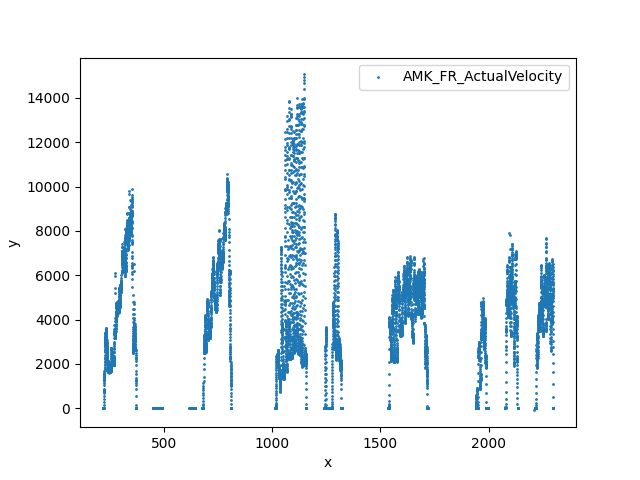

In [18]:
graph_channels([can_wheel_speed_channels[0]])

Dropped 33099 nan rows, remaining: 137915
Sum of the bad mask for gps: 0
Correcting for warp-around swangle values...
FSM_steeringWheelAngleADC
AMK_FR_TorqueLimitPositiv
AMK_FL_TorqueLimitPositiv
AMK_RR_TorqueLimitPositiv
AMK_BL_TorqueLimitPositiv
AMK_FR_ActualVelocity
Found 36597 points with too large of interpolation, changing to NaN...
AMK_FL_ActualVelocity
Found 36597 points with too large of interpolation, changing to NaN...
AMK_BR_ActualVelocity
Found 36597 points with too large of interpolation, changing to NaN...
AMK_BL_ActualVelocity
Found 36591 points with too large of interpolation, changing to NaN...
AMK_FR_TorqueLimitNegativ
AMK_FL_TorqueLimitNegativ
AMK_RR_TorqueLimitNegativ
AMK_BL_TorqueLimitNegativ
FSM_brakePressureFront
(67294, 3)
Index(['time', 'PacketCounter', 'StatusWord', 'Acc_X', 'Acc_Y', 'Acc_Z',
       'FreeAcc_E', 'FreeAcc_N', 'FreeAcc_U', 'Gyr_X', 'Gyr_Y', 'Gyr_Z',
       'rotation', 'yaw_orig', 'pitch', 'roll', 'Latitude', 'Longitude',
       'Vel_E', 'Vel_N'

VBox()

VBox()

VBox()

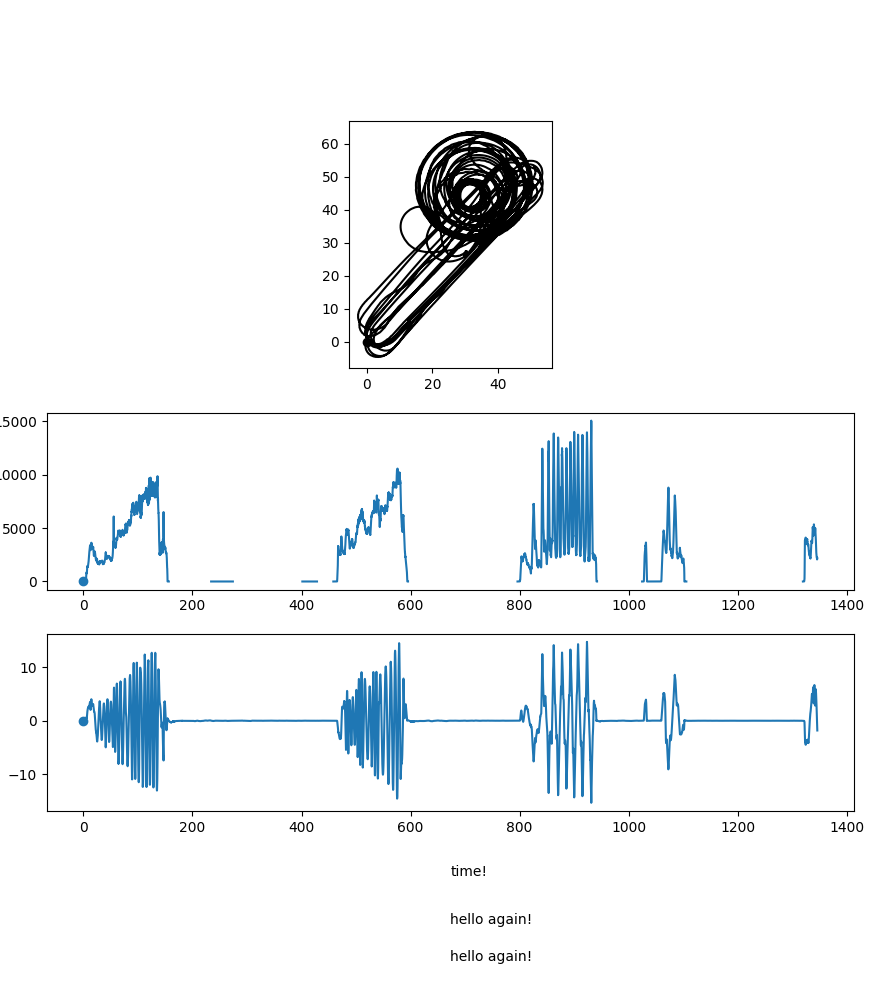

No such comm: 4b344d03a439410da37880dc648410b7


In [19]:
# START OF CALLS

df = create_evenly_spaced_table_unified()
transform(df)

print(df.columns)
show_table(df)
graph_xy(df, [can_wheel_speed_channels[0], gps_velocity_x_channel])

# show_table(df.loc[:, ['vlong_movella', 'vlong', 'vlat_movella', 'vlat']])

# show_table(df.loc[(5 * 10830):(5 *10880), ['vlong', 'vlat', 'swangle', 'torque', 'time', 'yaw']])
# graph_df_columns(df.loc[10830:10880, :], ['vlong', 'vlat', 'torque'])
# graph_xy(df, (5 * 10830, 5 *10880))


In [20]:
# graph_xy(df, [can_wheel_speed_channels[0], "Vel_E"])
pass

In [21]:
pass
# graph_xy(df_usable, ["vlat", "yawdot", "yaw", "xdot", "ydot", "rear_slip_angle"], bounds=(10, 30))

In [22]:
# Setting stuff up for the acceleration approximation objective function
# Wrap this in a closure in the future.
state_channels = bicycle_state_channels
controls_channels = bicycle_controls_channels
ref_channels = ['xdoubledot', 'ydoubledot', 'yawdot_ref', 'front_wheel_speed_ref', 'rear_wheel_speed_ref']
mask = np.zeros(df.shape[0], dtype=bool)
usable_intervals, validation_intervals = get_usable_intervals(df)
for start, _, end, _ in usable_intervals:
    mask[start:end] = True

df_usable = df.loc[mask, ['time'] + state_channels + controls_channels + ref_channels]



Intervals (unified): [(245, 4.8999999999955435, 6910, 138.1999999998743), (23276, 465.5199999995766, 29112, 582.2399999994705), (40059, 801.1799999992713, 47018, 940.3599999991447), (53007, 1060.1399999990358, 55096, 1101.9199999989978)]
Train intervals: [(245, 4.8999999999955435, 885, 17.699999999983902), (1045, 20.89999999998099, 1685, 33.69999999996935), (1845, 36.89999999996644, 2485, 49.6999999999548), (2645, 52.89999999995189, 3285, 65.69999999994025), (3445, 68.89999999993734, 4085, 81.6999999999257), (4245, 84.89999999992278, 4885, 97.69999999991114), (5045, 100.89999999990823, 5685, 113.69999999989659), (5845, 116.89999999989368, 6485, 129.69999999988204), (6645, 132.89999999987913, 6910, 138.1999999998743), (23276, 465.5199999995766, 23916, 478.31999999956497), (24076, 481.51999999956206, 24716, 494.3199999995504), (24876, 497.5199999995475, 25516, 510.31999999953587), (25676, 513.519999999533, 26316, 526.3199999995213), (26476, 529.5199999995184, 27116, 542.3199999995068), (

In [23]:
output_filename = None


# Account for load transfer
state_indexes = [df_usable.columns.get_loc(col) for col in state_channels]
control_indexes = [df_usable.columns.get_loc(col) for col in controls_channels]
xdoubledot_index = df_usable.columns.get_loc('xdoubledot')
ydoubledot_index = df_usable.columns.get_loc('ydoubledot')
yawdot_ref_index = df_usable.columns.get_loc('yawdot_ref')
front_wheel_speed_ref_index = df_usable.columns.get_loc('front_wheel_speed_ref')
rear_wheel_speed_ref_index = df_usable.columns.get_loc('rear_wheel_speed_ref')
time_index = df_usable.columns.get_loc('time')
stride = 1
# I am pretty sure we need to hardcode this to be exactly the
np_matrix_usable = df_usable.to_numpy()

In [24]:
# stride = 80
def generate_row_mask(time_column, stride):
    delta_time = timestep * stride
    row_mask = []
    for i in range(len(time_column) - stride):
        if np.isclose(time_column[i] + delta_time, time_column[i + stride]):
            row_mask.append(i)
    return np.array(row_mask)

def rotate(xworld, yworld, yaw):
    longitudinal = xworld * np.cos(yaw) + yworld * np.sin(yaw)
    lateral = -xworld * np.sin(yaw) + yworld * np.cos(yaw)
    return longitudinal, lateral

# row_mask = generate_row_mask(np_matrix_usable[:, time_index], stride)
# print(len(row_mask))
# print(row_mask)
# for i in range(len(row_mask)):
#     if i != row_mask[i]:
#         print(i)
#         print(row_mask[i])
#         break
# print(np_matrix_usable[638+stride:648+stride, time_index])

# print(np_matrix_usable[638:648, time_index])

# print(row_mask)
# print(row_mask + 6)
# print(np_matrix_usable[[0], :].shape)


Things to do
2. Change to work in world frame (so rotation-acceleration should be unnecessary (but may still be helpful))
4. Try various tire models (e.g. linear saturating, naive 4 parameter)
1. Optimize all parameters for all prediction at once
3. Better integration (find the spacing between can data points) or interpolation
4. clipping deceleration

I might have to grapple with the fact that I simply can't do this, not at my current skill level, or the current data.

So, then what? Use Griffin's model? I think it is still pretty inaccurate
I think do all of the above and choose the best one to productionize, even if it is inaccurate. 

Neural net?


In [25]:
# Master vectorized predictor
def master_predictor_setup(df_usable):
    # Account for load transfer
    state_indexes = [df_usable.columns.get_loc(col) for col in state_channels]
    control_indexes = [df_usable.columns.get_loc(col) for col in controls_channels]
    xdoubledot_index = df_usable.columns.get_loc('xdoubledot')
    ydoubledot_index = df_usable.columns.get_loc('ydoubledot')
    yawdot_ref_index = df_usable.columns.get_loc('yawdot_ref')
    front_wheel_speed_ref_index = df_usable.columns.get_loc('front_wheel_speed_ref')
    rear_wheel_speed_ref_index = df_usable.columns.get_loc('rear_wheel_speed_ref')
    time_index = df_usable.columns.get_loc('time')

    # I am pretty sure we need to hardcode this to be exactly the
    np_matrix_usable = df_usable.to_numpy()

    dummy_accel_params = np.array([0,0,aero_drag_coefficient,0,0,0,1,0.4, 0.4, 1,1])
    dummy_yawrate_params = np.array([car_rotational_inertia, 0,0,0,0,1,0.4,0.4])
    dummy_wheelspeed_params = np.array([4.23022, 0, 0, -2.6617, -2.237011, 0, 0])

    debugging_refs = np_matrix_usable[:, [xdoubledot_index, ydoubledot_index, yawdot_ref_index, front_wheel_speed_ref_index, rear_wheel_speed_ref_index]]


    def vectorized_predictor_master(state, action, accel_params, yawrate_params, wheel_params, refs=debugging_refs):
        assert len(accel_params) == 11, len(accel_params)
        a_longA, a_longB, a_longC, a_latA, a_latB, a_latC, a_load_transfer_scale, a_tire_model_longitudinal_scale, a_tire_model_lateral_scale, a_rotation_long_accel_scale, a_rotation_lat_accel_scale = accel_params
        assert len(yawrate_params) == 8, len(yawrate_params)
        car_rotational_inertia, yr_latA, yr_latB, yr_latC, yr_aero_moment_scale, yr_load_transfer_scale, yr_tire_model_longitudinal_scale, yr_tire_model_lateral_scale = yawrate_params
        assert len(wheel_params) == 7, len(wheel_params)
        wheel_rotational_inertia, w_front_constant, w_rear_constant, w_front_wheel_speed_coef, w_rear_wheel_speed_coef, w_load_transfer_scale, w_tire_model_longitudinal_scale = wheel_params


        yaw_world = state[:, 2]
        xdot_car = state[:, 3]
        ydot_car = state[:, 4]
        yaw_rate = state[:, 5]
        front_wheel_speed = state[:, 6]
        rear_wheel_speed = state[:, 7]
        a_long_old = state[:, 8]

        # Get control actions
        steering_angle = action[:, 0] + swangle_bias
        torque_front = action[:, 1] * 0.5 * gear_ratio
        torque_rear = action[:, 2] * 0.5 * gear_ratio

        v_long_car, v_lat_car = rotate(xdot_car, ydot_car, yaw_world)
        ## Calculate inputs to tire model

        # Slip angles
        # assert np.min(v_long_car) > 0, np.min(v_long_car)
        v_lat_at_front_tire = v_lat_car + yaw_rate * cg_to_front
        front_tire_velocity_angle = np.arctan(v_lat_at_front_tire / v_long_car)
        front_slip_angle = front_tire_velocity_angle - steering_angle
        v_lat_at_rear_tire = v_lat_car - yaw_rate * cg_to_rear
        rear_tire_speed = np.sqrt(v_long_car * v_long_car + v_lat_at_rear_tire * v_lat_at_rear_tire)
        rear_slip_angle = np.arcsin(np.clip(v_lat_at_rear_tire / rear_tire_speed, -1.0, 1.0))
        other = np.arctan(v_lat_at_rear_tire / v_long_car)
        assert np.abs(rear_slip_angle - other).max() < 1e-5, f"v_long: {v_long_car}, v_lat: {v_lat_at_rear_tire}"
        
        # assert abs(rear_slip_angle - alternate_slip_angle) < 1e-5, str(abs(rear_slip_angle - alternate_slip_angle))

        # Slip ratios
        velocity_along_front_tire = v_long_car * np.cos(steering_angle) + v_lat_at_front_tire * np.sin(steering_angle)
        other_vaft, _ = rotate(v_long_car, v_lat_at_front_tire, steering_angle)
        # other_vaft, _ = rotate(xdot_car, ydot_car, yaw_world + steering_angle)
        assert np.abs(velocity_along_front_tire - other_vaft).max() < 1e-5, f"v_long: {v_long_car}, v_lat: {v_lat_at_front_tire}"

        front_slip_ratio = calculate_slip_ratio(front_wheel_speed, velocity_along_front_tire)
        rear_slip_ratio = calculate_slip_ratio(rear_wheel_speed, v_long_car)
        # df_usable['front_slip_angle'] = front_slip_angle
        # df_usable['rear_slip_angle'] = rear_slip_angle
        # df_usable['front_slip_ratio'] = front_slip_ratio
        # df_usable['rear_slip_ratio'] = rear_slip_ratio

        # SPLIT HERE

        # Load transfer
        total_downforce = car_mass * gravity + aero_downforce_coefficient * (v_long_car ** 2)
        
        # Accel stuff
        a_front_to_back_transfer = a_load_transfer_scale * car_mass * a_long_old * cg_height / wheel_base
        a_front_load = (total_downforce * cg_to_rear / wheel_base) - a_front_to_back_transfer
        a_rear_load = (total_downforce * cg_to_front / wheel_base) + a_front_to_back_transfer
    
        a_front_force_along_tire, a_front_force_perpendicular_tire = get_forces(front_slip_ratio, front_slip_angle, a_front_load / 2, tire_pressure, 0)
        a_rear_force_along_tire, a_rear_force_perpendicular_tire = get_forces(rear_slip_ratio, rear_slip_angle, a_rear_load / 2, tire_pressure, 0)

        a_front_force_along_tire = a_front_force_along_tire * 2 * a_tire_model_longitudinal_scale
        a_front_force_perpendicular_tire = a_front_force_perpendicular_tire * 2 * a_tire_model_lateral_scale
        a_rear_force_along_tire = a_rear_force_along_tire * 2 * a_tire_model_longitudinal_scale
        a_rear_force_perpendicular_tire = a_rear_force_perpendicular_tire * 2 * a_tire_model_lateral_scale

        a_force_long_car = a_front_force_along_tire * np.cos(steering_angle) - a_front_force_perpendicular_tire * np.sin(steering_angle) + a_rear_force_along_tire
        a_force_lat_car_front = a_front_force_along_tire * np.sin(steering_angle) + a_front_force_perpendicular_tire * np.cos(steering_angle)
        a_force_lat_car_rear = a_rear_force_perpendicular_tire
        a_force_lat_car = a_force_lat_car_front + a_force_lat_car_rear

        a_force_long_car -= (a_longA + a_longB * v_long_car + a_longC * v_long_car ** 2)
        a_force_lat_car -= (a_latA + a_latB * v_lat_car + a_latC * v_lat_car ** 2)

        a_long_accel = a_force_long_car / car_mass# + v_lat_car * yaw_rate * a_rotation_long_accel_scale
        a_lat_accel = a_force_lat_car / car_mass# - v_long_car * yaw_rate * a_rotation_lat_accel_scale

        xdoubledot, ydoubledot = rotate(a_long_accel, a_lat_accel, -yaw_world)
        # REMOVE LATER: FOR SANITY CHECKING
        if refs is not None:
            xdoubledot, ydoubledot = refs[:, 0], refs[:, 1]

        # yawrate stuff
        yr_front_to_back_transfer = yr_load_transfer_scale * car_mass * a_long_old * cg_height / wheel_base
        yr_front_load = (total_downforce * cg_to_rear / wheel_base) - yr_front_to_back_transfer
        yr_rear_load = (total_downforce * cg_to_front / wheel_base) + yr_front_to_back_transfer
    
        yr_front_force_along_tire, yr_front_force_perpendicular_tire = get_forces(front_slip_ratio, front_slip_angle, yr_front_load / 2, tire_pressure, 0)
        yr_rear_force_along_tire, yr_rear_force_perpendicular_tire = get_forces(rear_slip_ratio, rear_slip_angle, yr_rear_load / 2, tire_pressure, 0)

        yr_front_force_along_tire = yr_front_force_along_tire * 2 * yr_tire_model_longitudinal_scale
        yr_front_force_perpendicular_tire = yr_front_force_perpendicular_tire * 2 * yr_tire_model_lateral_scale
        yr_rear_force_along_tire = yr_rear_force_along_tire * 2 * yr_tire_model_longitudinal_scale
        yr_rear_force_perpendicular_tire = yr_rear_force_perpendicular_tire * 2 * yr_tire_model_lateral_scale

        yr_force_lat_car_front = yr_front_force_along_tire * np.sin(steering_angle) + yr_front_force_perpendicular_tire * np.cos(steering_angle)
        yr_force_lat_car_rear = yr_rear_force_perpendicular_tire

        yr_aero_moment = (yr_latA + yr_latB * v_lat_car + yr_latC * v_lat_car ** 2) * yr_aero_moment_scale

        # wheel speed stuff
        w_front_to_back_transfer = w_load_transfer_scale * car_mass * a_long_old * cg_height / wheel_base
        w_front_load = (total_downforce * cg_to_rear / wheel_base) - w_front_to_back_transfer
        w_rear_load = (total_downforce * cg_to_front / wheel_base) + w_front_to_back_transfer
    
        w_front_force_along_tire, _ = get_forces(front_slip_ratio, front_slip_angle, w_front_load / 2, tire_pressure, 0)
        w_rear_force_along_tire, _ = get_forces(rear_slip_ratio, rear_slip_angle, w_rear_load / 2, tire_pressure, 0)

        w_front_force_along_tire = w_front_force_along_tire * 2 * w_tire_model_longitudinal_scale
        w_rear_force_along_tire = w_rear_force_along_tire * 2 * w_tire_model_longitudinal_scale

        # force_long_car -= (rolling_friction_coefficient * total_downforce + aero_drag_coefficient * (v_long_car ** 2)) 
        w_front_force_along_tire = w_front_force_along_tire - w_front_constant - w_front_wheel_speed_coef * front_wheel_speed
        w_rear_force_along_tire = w_rear_force_along_tire - w_rear_constant - w_rear_wheel_speed_coef * rear_wheel_speed
        front_wheel_speed_predicted = front_wheel_speed + ((torque_front - whl_radius * w_front_force_along_tire) / wheel_rotational_inertia) * timestep
        rear_wheel_speed_predicted = rear_wheel_speed + ((torque_rear - whl_radius * w_rear_force_along_tire) / wheel_rotational_inertia) * timestep

        a_long_accel = np.clip(a_long_accel, -v_long_car / timestep + 1e-5, None)

        # print(xdot_car.shape, ydot_car.shape, yaw_rate.shape, xdoubledot.shape, ydoubledot.shape, yr_force_lat_car_front.shape)
        state_diff = np.stack((
            (xdot_car * timestep),
            (ydot_car * timestep),
            (yaw_rate * timestep),
            (xdoubledot * timestep),
            (ydoubledot * timestep),
            ((cg_to_front * yr_force_lat_car_front - cg_to_rear * yr_force_lat_car_rear + yr_aero_moment) / car_rotational_inertia) * timestep,
            ((torque_front - whl_radius * w_front_force_along_tire) / wheel_rotational_inertia) * timestep,
            ((torque_rear - whl_radius * w_rear_force_along_tire) / wheel_rotational_inertia) * timestep,
            a_long_accel
        ), axis=-1)
        next_state = state + state_diff
        next_state[:, 8] = a_long_accel

        yaw_rate_predicted = next_state[:, 5]
        if refs is not None:
            next_state[:, 5] = refs[:, 2]
            yaw_rate_predicted = refs[:, 2]

        return xdoubledot, ydoubledot, yaw_rate_predicted, front_wheel_speed_predicted, rear_wheel_speed_predicted, next_state
    

    def accel_objective_master(params):
        # Cost variables
        xdoubledot_predicted, ydoubledot_predicted, _, _, _, _= vectorized_predictor_master(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], params, dummy_yawrate_params, dummy_wheelspeed_params)
        xdoubledot, ydoubledot = np_matrix_usable[:, xdoubledot_index], np_matrix_usable[:, ydoubledot_index]
        cost = np.abs(xdoubledot_predicted - xdoubledot) + np.abs(ydoubledot_predicted - ydoubledot)
        return cost.sum() / len(cost)
    
    def yawrate_objective_master(params):
        _, _, yaw_rate_predicted, _, _, _ = vectorized_predictor_master(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], dummy_accel_params, params, dummy_wheelspeed_params)
        yaw_rate = np_matrix_usable[:, yawdot_ref_index]
        cost = np.abs(yaw_rate - yaw_rate_predicted).mean()
        return cost

    def wheel_objective_master(params):
        _, _, _, front_wheel_speed_predicted, rear_wheel_speed_predicted, _ = vectorized_predictor_master(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], dummy_accel_params, dummy_yawrate_params, params)
        front_wheel_speed_ref, rear_wheel_speed_ref = np_matrix_usable[:, front_wheel_speed_ref_index], np_matrix_usable[:, rear_wheel_speed_ref_index]
        cost = np.abs(front_wheel_speed_predicted - front_wheel_speed_ref) + np.abs(rear_wheel_speed_predicted - rear_wheel_speed_ref)
        return cost.sum() / len(cost)
    
    def accel_validation(params):
        return None
        # along_predicted, alat_predicted, _, _, _, _= vectorized_predictor_master(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], params, dummy_yawrate_params, dummy_wheelspeed_params)
        # along, alat = np_matrix_usable[:, along_index], np_matrix_usable[:, alat_index]        
        # return np.abs(along_predicted - along).mean(), np.abs(alat_predicted - alat).mean()
    
    def strided_objective(params, stride=80):
        assert len(params) == len(dummy_accel_params) + len(dummy_yawrate_params) + len(dummy_wheelspeed_params)
        accel_params = params[:len(dummy_accel_params)]
        yawrate_params = params[len(dummy_accel_params):len(dummy_accel_params) + len(dummy_yawrate_params)]
        wheel_params = params[len(dummy_accel_params) + len(dummy_yawrate_params):]
        initial_row_mask = generate_row_mask(np_matrix_usable[:, time_index], stride)
        state = np_matrix_usable[initial_row_mask, :][:, state_indexes]
        for iteration in range(stride):
            control_action = np_matrix_usable[initial_row_mask + iteration, :][:, control_indexes]
            refs = np_matrix_usable[initial_row_mask + iteration, :][:, [xdoubledot_index, ydoubledot_index, yawdot_ref_index, front_wheel_speed_ref_index, rear_wheel_speed_ref_index]]
            _, _, _, _, _, state = vectorized_predictor_master(state, control_action, accel_params, yawrate_params, wheel_params, refs)
        # print(initial_row_mask)
        # print(initial_row_mask + stride)
        assert np.isclose(np_matrix_usable[initial_row_mask + stride, time_index],
                          np_matrix_usable[initial_row_mask, time_index] + timestep * stride).any()
        actual_state = np_matrix_usable[initial_row_mask + stride, :][:, state_indexes]
        state_diff = state - actual_state
        mean_dist_squared = np.mean(state_diff[:, 0] ** 2 + state_diff[:, 1] ** 2)
        return mean_dist_squared
        
    
    return vectorized_predictor_master, accel_objective_master, yawrate_objective_master, wheel_objective_master, accel_validation, strided_objective



# # Converts vectorized_predictor into a dynamics_function that simulate and compute cost can accept
# # Funky
# # Please don't put this anywhere close to autograd
# def get_dynamics_function_from_vectorized(params, car_rotational_inertia, wheel_rotational_inertia):
    
#     def dynamics_function(state, action):
#         return vectorized_predictor(state, action, params, car_rotational_inertia=car_rotational_inertia, wheel_rotational_inertia=wheel_rotational_inertia)[5]
    
#     return dynamics_function

0.0
0.0


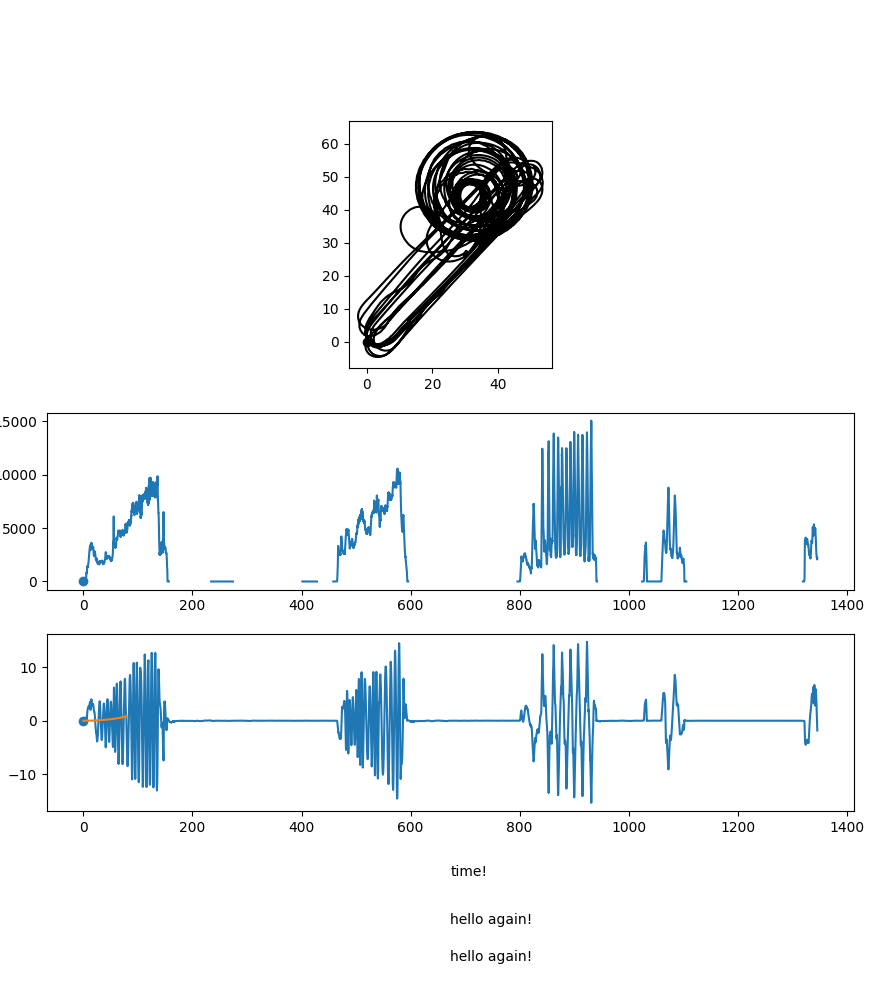

In [ ]:
vectorized_predictor_master, accel_objective_master, yawrate_objective_master, wheel_objective_master, accel_validation, strided_objective = master_predictor_setup(df_usable)
accel_initial_params = np.array([0,0,aero_drag_coefficient,0,0,0,1,0.4, 0.4, 1, 1])
yawrate_initial_params = np.array([car_rotational_inertia, 0.0,0.0,0.0,0.0,1,0.4,0.4])
wheel_initial_params = np.array([0.04008045, 0.0, 0.0, 0.5, 0.5, 1.0, 0.4])

params = np.hstack((accel_initial_params, yawrate_initial_params, wheel_initial_params))
# print(params.shape)
# np_matrix_usable[:, state_indexes]
print(accel_objective_master(accel_initial_params))
print(yawrate_objective_master(yawrate_initial_params))

y = []
for i in range(80):
    y.append(strided_objective(params, i))

# strided_objective(params, 80) 
# vectorized_predictor_master(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], accel_initial_params, yawrate_initial_params, wheel_initial_params)

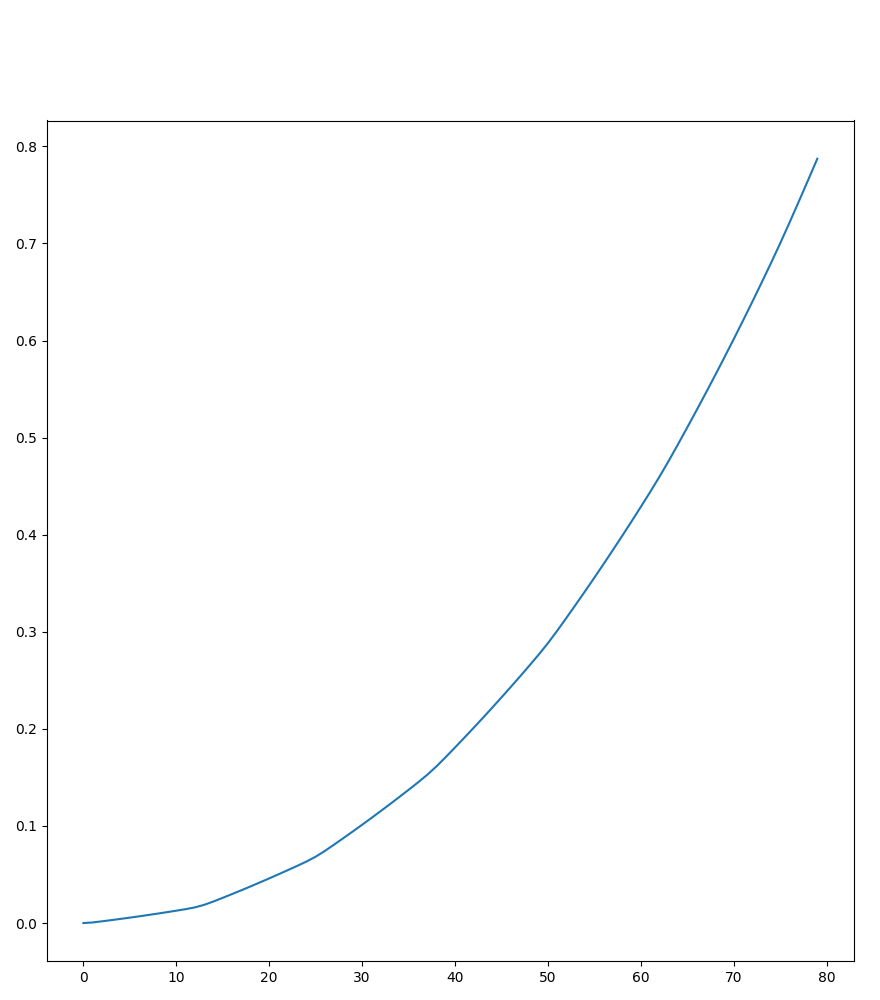

In [27]:
plt.clf()
plt.plot(np.arange(80), y)
plt.show()

In [ ]:
show_table(df_usable)
vectorized_predictor_master, accel_objective_master, yawrate_objective_master, wheel_objective_master, accel_validation = master_predictor_setup(df_usable)

# bounds = [(0, None)] * 9 + [(None, None)] * 2
# note that I scaled 4th param down by 10 and last param up by 10
accel_initial_params = np.array([0,0,aero_drag_coefficient,0,0,0,1,0.4, 0.4, 1, 1])
yawrate_initial_params = np.array([car_rotational_inertia, 0.0,0.0,0.0,0.0,1,0.4,0.4])
wheel_initial_params = np.array([0.04008045, 0.0, 0.0, 0.5, 0.5, 1.0, 0.4])

accel_minimize_result = basinhopping(accel_objective_master, accel_initial_params, niter = 200, seed=251, T=0.1, stepsize=5, minimizer_kwargs={'method': "SLSQP", "jac": grad(accel_objective_master)})
yawrate_minimize_result = basinhopping(yawrate_objective_master, yawrate_initial_params, niter = 200, seed=251, T=0.1, stepsize=5, minimizer_kwargs={'method': "SLSQP", "jac": grad(yawrate_objective_master)})
wheel_minimize_result = basinhopping(wheel_objective_master, wheel_initial_params, niter = 200, seed=251, T=0.1, stepsize=5, minimizer_kwargs={'method': "SLSQP", "jac": grad(wheel_objective_master)})


In [ ]:
vectorized_predictor_master, accel_objective_master, yawrate_objective_master, wheel_objective_master, accel_validation = master_predictor_setup(df_usable)

# Validation of everything
print("----Acceleration stuff----")
print(accel_minimize_result.x)
print(accel_validation(accel_initial_params))
print(accel_validation(accel_minimize_result.x))

print("----Yawrate stuff----")
print(yawrate_minimize_result.x)
print(np.abs(df_usable["yawdot"] - df_usable["yawdot_ref"]).mean())
print(yawrate_objective_master(yawrate_initial_params))
print(yawrate_objective_master(yawrate_minimize_result.x))

print("----Wheel stuff----")
print(wheel_minimize_result.x)
print(np.abs(df_usable["front_wheel_speed"] - df_usable["front_wheel_speed_ref"]).mean() + np.abs(df_usable["rear_wheel_speed"] - df_usable["rear_wheel_speed_ref"]).mean())
print(wheel_objective_master(wheel_initial_params))
print(wheel_objective_master(wheel_minimize_result.x))
print(wheel_objective_master(np.array([1000000, 0, 0, 0, 0, 0, 0])))


# along_predicted_orig, alat_predicted_orig = vectorized_predictor_master(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], accel_initial_params)
# along_predicted, alat_predicted = vectorized_predictor_master(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], accel_minimize_result.x)
# along, alat = np_matrix_usable[:, along_index], np_matrix_usable[:, alat_index]
# print(along_predicted.shape[0])
# print(np.abs(along_predicted_orig - along).mean())
# print(np.abs(alat_predicted_orig - alat).mean())
# print(np.abs(along_predicted - along).mean())
# print(np.abs(alat_predicted - alat).mean())
# print(np.sum(np.sign(along_predicted) != np.sign(along)))
# print(np.sum(np.sign(alat_predicted) != np.sign(alat)))

In [ ]:
# Validation
vectorized_predictor_master, accel_objective_master, yawrate_objective_master, wheel_objective_master, accel_validation = master_predictor_setup(df_usable)
from functools import partial
from operator import itemgetter
def partial_return_wrapper(func, idx):
    def inner_func(*args, **kwargs):
        return func(*args, **kwargs)[idx]
    return inner_func
dynamics_func = partial_return_wrapper(partial(vectorized_predictor_master, accel_params=accel_minimize_result.x, yawrate_params=yawrate_minimize_result.x, wheel_params=wheel_minimize_result.x), 5)
dynamics_func_orig = partial_return_wrapper(partial(vectorized_predictor_master, accel_params=accel_initial_params, yawrate_params=yawrate_initial_params, wheel_params=wheel_initial_params), 5)

# state = df.loc[0, bicycle_state_channels]
# action = df_usable[bicycle_controls_channels].to_numpy()
# print(state.shape)
# print(type(state))
# # dynamics_func(state, action).shape
# print(state.index)

simulate_and_compute_cost(dynamics_func_orig, df, bicycle_state_channels, bicycle_controls_channels, cost_function=None, stride=40, output_filename="vectorized_validation_bleh.txt", usable_intervals=validation_intervals)
# with open("vectorized_validation.txt", 'w') as f:
    # f.write("")
# simulate_and_compute_cost(dynamics_func, df, bicycle_state_channels, bicycle_controls_channels, cost_function=None, stride=40, output_filename="vectorized_validation.txt", usable_intervals=validation_intervals)

In [ ]:
# I mainly use this cell to load the data frame with slip ratios and slip angles for sanity checking
initial_params = np.array([0,0,aero_drag_coefficient,0,0,0,1,0.4, 0.4, 1])
along_predicted, alat_predicted = vectorized_predictor(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], initial_params)


In [ ]:
# # Validation of optimized parameters
# # optimized_params = np.array([0.05956025,  0,         9.37492417,  0.13667043, 20.38967366,  10, 1.45987        ])
# print(optimized_params)
# print(differentiable_objective_fast(optimized_params))
# print(grad(differentiable_objective_fast)(optimized_params))
# print(approx_fprime(optimized_params, differentiable_objective_fast))


In [ ]:
# Optimization of wheel speed prediction

output_filename = None

# bounds = [(0, None)] * 9 + [(None, None)] * 2
# note that I scaled 4th param down by 10 and last param up by 10
initial_params_wheel_speed = np.array([0.04008045, 0, 0, 0.5, 0.5, 1, 0.4])

wheel_gradient_function = grad(wheel_speed_differentiable_objective_fast)
minimizer_kwargs = {'method': "SLSQP", "jac": wheel_gradient_function}

wheel_speed_differentiable_objective_fast(initial_params_wheel_speed)

# minimize_result = minimize(differentiable_objective_fast, initial_params, method="SLSQP", jac=gradient_function, bounds=bounds)
minimize_result = basinhopping(wheel_speed_differentiable_objective_fast, initial_params_wheel_speed, niter = 20, seed=25, T=0.1, stepsize=5, minimizer_kwargs=minimizer_kwargs)
optimized_params = minimize_result.x
print(optimized_params)

In [ ]:
print(optimized_params)
naive_params = np.array([1000000, 0, 0, 0, 0, 0, 0])
boutique_params = np.array([4.23022, 0, 0, -2.6617, -2.237011, 0, 0])
front_wheel_speed_predicted_orig, rear_wheel_speed_predicted_orig = vectorized_wheel_speed_predictor(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], optimized_params)
front_wheel_speed_predicted, rear_wheel_speed_predicted = vectorized_wheel_speed_predictor(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], optimized_params)
front_wheel_speed_ref, rear_wheel_speed_ref = np_matrix_usable[:, front_wheel_speed_ref_index], np_matrix_usable[:, rear_wheel_speed_ref_index]
print(np.abs(front_wheel_speed_predicted_orig - front_wheel_speed_ref).mean())
print(np.abs(rear_wheel_speed_predicted_orig - rear_wheel_speed_ref).mean())
print(np.abs(front_wheel_speed_predicted - front_wheel_speed_ref).mean())
print(np.abs(rear_wheel_speed_predicted - rear_wheel_speed_ref).mean())
print(front_wheel_speed_ref.max())
print(front_wheel_speed_ref.mean())
print(show_table(df_usable[["front_torque", "front_backtorque", "front_wheel_speed_predicted"]]))

In [ ]:
plt.clf()
# plt.scatter(df_usable["rear_slip_ratio"], df_usable["along"], s=1)
# plt.scatter(df_usable["rear_slip_ratio"], df_usable["rear_force_along_tire"], s=1)
# plt.scatter(df_usable["rear_slip_angle"], df_usable["alat"], s=1, color='red')
# plt.scatter(df_usable["rear_slip_angle"], df_usable["blep1"] / 100, s=1, color='blue')
plt.scatter(df_usable["rear_slip_angle"], df_usable["vlat"], s=1, color='green')


# plt.xlabel("Rear slip ratio")
# plt.ylabel("Acceleration along the car's body")
plt.show()

In [ ]:
# For each row, if slip ratio is negative, calculate how long it takes for acceleration to become negative


In [ ]:

stdevs = df.loc[:, bicycle_state_channels].std()
def cost_function(error_vector):
    cost = 0
    for i, quantity in enumerate(bicycle_state_channels[3:5], start=3):
        cost += abs(error_vector[i]) / stdevs[quantity]
    return cost
params_names = ['rolling_friction_coefficient', 'aero_drag_coefficient', 'aero_downforce_coefficient', 'tire_model_longitudinal_scale', 'tire_model_lateral_scale', 'swangle_bias', 'car_rotational_inertia', 'wheel_rotational_inertia'] 

# TODO: choose where to store validation results, then reference it after the cell is done running.
validation_report_filename = "<a place to store your information>" 
optimized_dynamics_function = get_dynamics_function_from_vectorized(optimized_params, car_ri_minimized.x[0], wheel_ri_minimized.x[0])
simulate_and_compute_cost(optimized_dynamics_function, df, bicycle_state_channels, bicycle_controls_channels, cost_function, stride=1, output_filename=validation_report_filename, usable_intervals=validation_intervals)


In [ ]:
from scipy.stats import linregress
from sklearn.linear_model import SGDRegressor

plt.clf()

x = df_usable['rear_torque']
y = (df_usable['rear_wheel_speed_ref'] - df_usable['rear_wheel_speed'])
boolean_filter = (x >= -17) & (x <= 20)
x = x[boolean_filter]
y = y[boolean_filter]

plt.scatter(x, y, s=1)

# reg = SGDRegressor(fit_intercept=False).fit(x.to_frame(), y)
# print(reg.coef_[0])
# y_pred = reg.predict(x.to_frame())
# plt.plot(x, y_pred, color='orange')

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print(slope, intercept, r_value, p_value, std_err)
upper_slope = 0.04008045
lower_slope=0.025
# plt.plot(x, slope * x + intercept, color='cyan')
plt.plot(x, upper_slope * x, color='red')
plt.plot(x, lower_slope * x, color='cyan')

plt.xlabel("Motor torque (Nm)")
plt.ylabel("Time derivative of rear wheel speed")
plt.show()

# print(np.abs(y - y_pred).sum() / len(y))
# print(np.abs(y - slope * x).sum() / len(y))
# print(np.abs(y - slope * x - intercept).sum() / len(y))

In [ ]:
plt.clf()

slope_hypothesis = 0.04008045 # should be equal to (0.5 * gear_ratio * timestep = 0.1393) / rotational inertia
mask = (df_usable['yawdot'] > -10000) & (df_usable['yawdot'] < 10000)
extra_torque = df_usable['rear_torque'] * slope_hypothesis - (df_usable['rear_wheel_speed_ref'] - df_usable['rear_wheel_speed']) # this should be friction-induced torque
print(np.abs(extra_torque).sum() / len(extra_torque))
# print(df_usable.loc[:, 'rear_wheel_speed'].describe())

plt.scatter(df_usable.loc[mask, 'rear_slip_ratio'], extra_torque[mask] - df_usable.loc[mask, 'rear_force_along_tire'] * coefficient * 0.02, s=1)
coefficient = whl_radius * slope_hypothesis * 2 / gear_ratio
fake_force, _ = get_forces(df_usable.loc[mask, 'rear_slip_ratio'], df_usable.loc[mask, 'rear_slip_angle'], df_usable.loc[mask, 'rear_load'] / 2, tire_pressure, 0)
# plt.scatter(df_usable.loc[mask, 'rear_slip_ratio'], fake_force * coefficient * 0.4 * 0.4, color='green', s=1)
# plt.scatter(df_usable.loc[mask, 'rear_slip_ratio'], , color='red', s=1)
# plt.scatter(df_usable.loc[mask, 'rear_slip_ratio'], df_usable.loc[mask, 'rear_wheel_speed'] * 0.001, color='green', s=1)

# plt.xlim(0, 0.3)
# plt.ylim(-1, 1)
plt.show()
# print(np.sum(np.abs(test_array) ** 2))
# test_array2 = y - z * 0.007096
# print(np.sum(np.abs(test_array2) ** 2))
# print(np.sum(np.abs(y) ** 2))
# print(df_usable.columns)
show_table(df_usable.loc[:, ['rear_load']])
# Findings: yawdot helps to partition the data (ish).
# Examining a close to 0 yawdot, slip ratios seem to be relevant, though probably coupled with some other factor

In [ ]:
_, _, _, _, rear_predicted, _, _, backtorque, _ = vectorized_predictor(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], optimized_params)

z = df_usable['rear_torque'] - backtorque

slope, intercept, r_value, p_value, std_err = linregress(z, y)

print(slope, intercept, r_value, p_value, std_err)

fig, ax = plt.subplots()
ax.scatter(z, y, s=1)
ax.set_xlabel("Motor torque - Tire model longitudinal force * Wheel radius(Nm)")
ax.set_ylabel("Time derivative of rear wheel speed")
ax.plot(z, slope * z + intercept, color='red')
plt.show()

In [ ]:
_, _, _, _, _, _, _, _, front_backtorque = vectorized_predictor(np_matrix_usable[:, state_indexes], np_matrix_usable[:, control_indexes], optimized_params)

front_z = df_usable['front_torque']
front_y = df_usable['front_wheel_speed_ref'] - df_usable['front_wheel_speed']
slope, intercept, r_value, p_value, std_err = linregress(front_z, front_y)

print(slope, intercept, r_value, p_value, std_err)
    
    # assert abs(rear_slip_angle - alternate_slip_angle) < 1e-5, str(abs(rear_slip_angle - alternate_slip_angle))

fig, ax = plt.subplots()
ax.scatter(front_z, front_y, s=1)
ax.set_xlabel("Motor torque - Tire model longitudinal force * Wheel radius(Nm)")
ax.set_ylabel("Time derivative of rear wheel speed")
ax.plot(front_z, slope * front_z + intercept, color='red')
plt.show()

In [ ]:
car_ri_objective, wheel_ri_objective = get_objectives(optimized_params)
car_minimizer_kwargs = {'method': "SLSQP", "bounds": [(1, 200)]}
# car_ri_minimized = basinhopping(car_ri_objective, car_rotational_inertia, niter=1000, T=0.025, stepsize=10, callback=checkpoint_optimization, minimizer_kwargs=car_minimizer_kwargs)


In [ ]:
car_ri_objective(car_rotational_inertia)

"""
        print(diff)
        print(np_matrix_usable[:, 5])
        print(yawrate_predicted)
        yawrate = np_matrix_usable[:, yawdot_ref_index]
        print(yawrate)
        """

In [ ]:
inertias = np.arange(1, 200, 0.5)
car_ri_objectives = [car_ri_objective(inertia) for inertia in inertias]

plt.clf()
plt.plot(inertias, car_ri_objectives)
plt.xlabel("Rotational Inertia")
plt.ylabel("Cost")
plt.show()


In [ ]:
print(car_ri_minimized.x)
print(car_ri_objective(car_rotational_inertia))
print(car_ri_objective(car_ri_minimized.x))
print(grad(car_ri_objective)(car_ri_minimized.x))
print(approx_fprime(car_ri_minimized.x, car_ri_objective))

In [ ]:
car_ri_objective_initial, _ = get_objectives(initial_params)
print(car_ri_objective_initial(car_rotational_inertia))
print(car_ri_objective_initial(car_ri_minimized.x))

In [ ]:
wheel_inertias = np.arange(0.1, 1, 0.001)
wheel_ri_objectives = [wheel_ri_objective(inertia) for inertia in wheel_inertias]

plt.clf()
plt.plot(wheel_inertias, wheel_ri_objectives)
plt.xlabel("Rotational Inertia")
plt.ylabel("Cost")
plt.show()


In [ ]:
wheel_minimizer_kwargs = {'method': "SLSQP", "bounds": [(0, None)]}
wheel_ri_minimized = basinhopping(wheel_ri_objective, wheel_rotational_inertia, niters=1000T=0.1, stepsize=0.01, callback=checkpoint_optimization, minimizer_kwargs=wheel_minimizer_kwargs)


In [ ]:
# SANITY CHECKING SLIP RATIO AND SLIP ANGLE VALUES

# Calculate slip ratios
temp_state = np_matrix_usable[:, state_indexes]

v_long_car = temp_state[:, 3]
v_lat_car = temp_state[:, 4]
yaw_rate = temp_state[:, 5]
front_wheel_speed = temp_state[:, 6]
rear_wheel_speed = temp_state[:, 7]

rear_slip_ratio = calculate_slip_ratio(rear_wheel_speed, v_long_car)

pd.DataFrame(rear_slip_ratio).describe()

# calculate slip angles

# Get control actions
steering_angle = np_matrix_usable[:, control_indexes][:, 0]
# Calculate inputs to tire model

# Slip angles
v_lat_at_front_tire = v_lat_car + yaw_rate * cg_to_front
front_tire_velocity_angle = np.arctan(v_lat_at_front_tire / v_long_car)
front_slip_angle = front_tire_velocity_angle - steering_angle
v_lat_at_rear_tire = v_lat_car - yaw_rate * cg_to_rear
rear_tire_speed = np.sqrt(v_long_car * v_long_car + v_lat_at_rear_tire * v_lat_at_rear_tire)
rear_slip_angle = np.arcsin(np.clip(v_lat_at_rear_tire / rear_tire_speed, -1.0, 1.0))

print(pd.DataFrame(front_slip_angle).describe())
print(pd.DataFrame(rear_slip_angle).describe())